<a href="https://colab.research.google.com/github/Yohan0358/Study_GAN/blob/main/pix2pix(210720).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import glob
import time

import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import torchvision.transforms as transforms
from torchvision.utils import make_grid

from PIL import Image

import cv2

In [ ]:
!git clone https://github.com/mrzhu-cool/pix2pix-pytorch
!unzip pix2pix-pytorch/dataset/facades.zip

In [3]:
path_img  = './facades/train/'

In [4]:
class Custom_dataset(Dataset):
    def __init__(self, path_img, transforms = None):
        super(Custom_dataset, self).__init__()

        self.train_img = sorted(glob.glob(path_img + 'b/*'))
        self.target_img = sorted(glob.glob(path_img + 'a/*'))

        if transforms:
            self.train_transform = transforms[0]
            self.target_transform = transforms[1]

    def __len__(self):
        return len(self.target_img)

    def __getitem__(self, idx):

        train_img = cv2.imread(self.train_img[idx])
        train_img = cv2.cvtColor(train_img, cv2.COLOR_BGR2RGB)

        target_img = cv2.imread(self.target_img[idx])
        target_img = cv2.cvtColor(target_img, cv2.COLOR_BGR2RGB)

        if transforms:
            train_img = self.train_transform(train_img)
            target_img = self.target_transform(target_img)

        return train_img, target_img

In [5]:
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                transforms.Resize(256)
])
dataset = Custom_dataset(path_img, [transform, transform])
s1, s2 = next(iter(dataset))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 256, 256]) torch.Size([3, 256, 256])


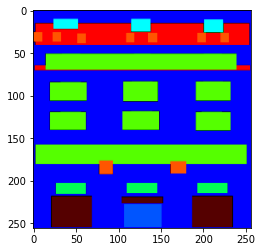

In [6]:
print(s1.shape, s2.shape)
plt.imshow(np.transpose(s1, (1, 2, 0)))

In [7]:
'''
Pix2Pix Generator model
C : Conv - BatchNorm - ReLU
CD : Conv - BatchNorm - Dropout - ReLu

Encoder
C64-C128-C256-C512-C512-C512-C512-C512

Decoder
CD512-CD512-CD512-C512-C256-C128-C64

U-Net Decoder
CD512-CD1024-CD1024-C1024-C1024-C512-C256-C128

d1                                                          u8
    d2                                                  u7
        d3                                          u6
            d4                                  u5
                d5                          u4
                    d6                  u3
                        d7          u2
                            d8  u1


'''

class pix2pix(nn.Module):
    def __init__(self, in_ch = 3, nf = 64):
        super(pix2pix, self).__init__()

        self.d1 = nn.Sequential(
            nn.Conv2d(in_ch, nf, 4, 2, 1),
            nn.LeakyReLU(0.2))
        self.d2 = self._encoder_block(nf, nf * 2)
        self.d3 = self._encoder_block(nf * 2 , nf * 4)
        self.d4 = self._encoder_block(nf * 4 , nf * 8)
        self.d5 = self._encoder_block(nf * 8 , nf * 8)
        self.d6 = self._encoder_block(nf * 8 , nf * 8)
        self.d7 = self._encoder_block(nf * 8 , nf * 8)
        self.d8 = nn.Sequential(
            nn.Conv2d(nf * 8, nf * 8, 4, 2, 1),
            nn.LeakyReLU(0.2))
        self.u1 = self._decoder_block(nf * 8 , nf * 8, drop_out = True)
        self.u2 = self._decoder_block(nf * 8 * 2 , nf * 8, drop_out = True)
        self.u3 = self._decoder_block(nf * 16 , nf * 8, drop_out = True)
        self.u4 = self._decoder_block(nf * 16 , nf * 8)
        self.u5 = self._decoder_block(nf * 16 , nf * 4)
        self.u6 = self._decoder_block(nf * 8 , nf * 2)
        self.u7 = self._decoder_block(nf * 4 , nf * 1)
        self.u8 = nn.Sequential(
            nn.ConvTranspose2d(nf * 2, 3, 4, 2, 1),
            nn.Tanh()
        )


    def _encoder_block(self, in_ch, out_ch, kernel_size = 4, stride = 2, padding = 1):
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size, stride, padding),
            nn.BatchNorm2d(out_ch),
            nn.LeakyReLU(0.2)
        )

    def _decoder_block(self, in_ch, out_ch, kernel_size = 4, stride = 2, padding = 1, drop_out = False):
        seq = nn.Sequential(
            nn.ConvTranspose2d(in_ch, out_ch, kernel_size, stride, padding),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(0.2))
        return nn.Sequential(seq, nn.Dropout(0.5)) if drop_out else seq


    def forward(self, x):
        d1 = self.d1(x)     # 64 x 128 x 128
        d2 = self.d2(d1)    # 128 x 64 x 64
        d3 = self.d3(d2)    #32
        d4 = self.d4(d3)    #16
        d5 = self.d5(d4)    #8
        d6 = self.d6(d5)    #4
        d7 = self.d7(d6)    #2
        d8 = self.d8(d7)    #1
        u1 = self.u1(d8)
        u2 = self.u2(torch.cat([u1, d7], dim = 1))
        u3 = self.u3(torch.cat([u2, d6], dim = 1))
        u4 = self.u4(torch.cat([u3, d5], dim = 1))
        u5 = self.u5(torch.cat([u4, d4], dim = 1))
        u6 = self.u6(torch.cat([u5, d3], dim = 1))
        u7 = self.u7(torch.cat([u6, d2], dim = 1))
        u8 = self.u8(torch.cat([u7, d1], dim = 1))
        return u8

def test():
    x = torch.randn((1, 3, 256, 256))
    G = pix2pix()
    out = G(x)
    print(out.shape)

test()

torch.Size([1, 3, 256, 256])


In [8]:
class Discriminator(nn.Module):
    def __init__(self, nf = 64):
        super().__init__()

        self.main = nn.Sequential(
            nn.Conv2d(6, nf, 4, 2, 1, bias = False),
            nn.LeakyReLU(0.2),
            self._block(nf, nf * 2),
            self._block(nf * 2, nf * 4),
            self._block(nf * 4, nf * 8, 4, 1, 1),
            nn.Conv2d(nf * 8, 1, 4, 1, 1, bias = False),
            nn.Sigmoid()
        )

    def _block(self, in_ch, out_ch, kernel_size = 4, stride = 2, padding = 1):
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size, stride, padding, bias = False),
            nn.BatchNorm2d(out_ch),
            nn.LeakyReLU(0.2)
        )

    def forward(self, x, y):
        z = torch.cat([x, y], dim = 1)    
        z = self.main(z)
        return z

def test():
    x = torch.randn(1, 3, 256, 256)
    D = Discriminator()
    output = D(x,x)
    print(output.shape)

test()

torch.Size([1, 1, 30, 30])


In [9]:
def weight_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.01)
        nn.init.constant_(m.bias.data, 0)

In [44]:
# hyperparameter
#train
epochs = 200
batch_size = 1
lamb = 100

loader = DataLoader(dataset, batch_size, shuffle = True)

#optimizer
lr = 2e-4
b1 = 0.5
b2 = 0.999

# Loss function
cGAN_loss = nn.BCELoss()
L1_loss = nn.L1Loss()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device :', device)

G = pix2pix().to(device)
D = Discriminator().to(device)

weight_init(G)
weight_init(D)

G_optim = optim.Adam(G.parameters(), lr = lr , betas=(b1, b2))
D_optim = optim.Adam(D.parameters(), lr = lr , betas=(b1, b2))

def imshow_grid(img, figsize = (10, 4)):
    img = make_grid(img.cpu().detach())
    np_img = np.transpose(img.numpy(), (1, 2, 0)) * 0.5 + 0.5
    plt.figure(figsize = figsize)
    plt.imshow(np_img)
    plt.show()

Device : cuda


Train is starting
Epochs : 200
learning rate : 0.0002
lambda : 100
[5 / 200 epochs] [400 / 400] batchs 	 D_loss : 0.000467 	 G_loss : 43.651009 	 time : 366.63492798805237


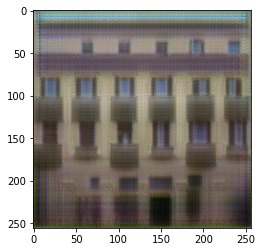

[10 / 200 epochs] [400 / 400] batchs 	 D_loss : 0.000029 	 G_loss : 42.423248 	 time : 732.7845945358276


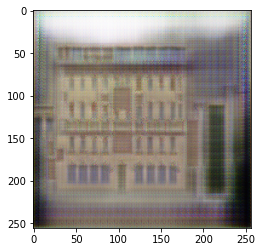

[15 / 200 epochs] [400 / 400] batchs 	 D_loss : 0.000014 	 G_loss : 43.961872 	 time : 1098.8025143146515


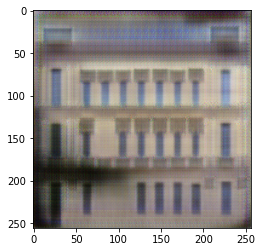

[20 / 200 epochs] [400 / 400] batchs 	 D_loss : 0.000003 	 G_loss : 36.533619 	 time : 1465.5160479545593


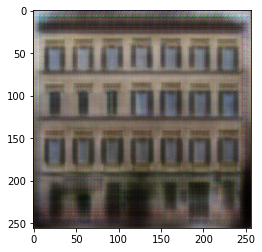

[25 / 200 epochs] [400 / 400] batchs 	 D_loss : 0.000001 	 G_loss : 40.607368 	 time : 1832.0517632961273


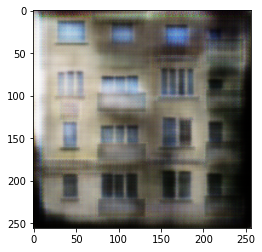

[30 / 200 epochs] [400 / 400] batchs 	 D_loss : 0.000001 	 G_loss : 35.008926 	 time : 2199.3887073993683


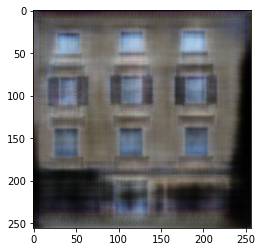

[35 / 200 epochs] [400 / 400] batchs 	 D_loss : 0.000000 	 G_loss : 33.458172 	 time : 2566.0931165218353


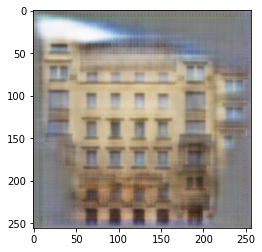

[40 / 200 epochs] [400 / 400] batchs 	 D_loss : 0.000000 	 G_loss : 31.125080 	 time : 2933.3929567337036


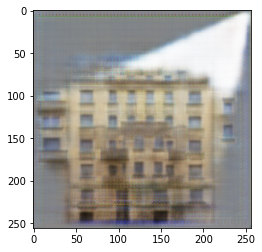

[45 / 200 epochs] [400 / 400] batchs 	 D_loss : 0.000000 	 G_loss : 37.733536 	 time : 3299.4482021331787


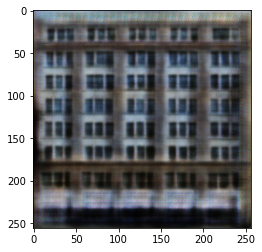

[50 / 200 epochs] [400 / 400] batchs 	 D_loss : 0.000000 	 G_loss : 32.937241 	 time : 3662.274065732956


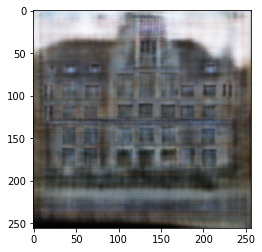

[55 / 200 epochs] [400 / 400] batchs 	 D_loss : 0.000000 	 G_loss : 35.301212 	 time : 4024.714884519577


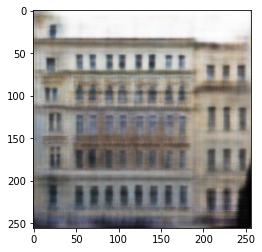

[60 / 200 epochs] [400 / 400] batchs 	 D_loss : 0.000000 	 G_loss : 35.646484 	 time : 4386.253210306168


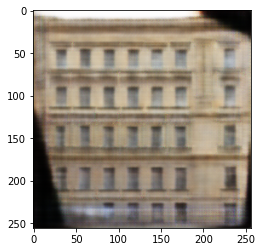

KeyboardInterrupt: ignored

In [16]:
# train

print('Train is starting')
print(f'Epochs : {epochs}\nlearning rate : {lr}\nlambda : {lamb}')
train_hist = {}
train_hist['D_loss'] = []
train_hist['G_loss'] = []


t = time.time()

for epoch in range(epochs):
    D_losses = 0
    G_losses = 0

    for i, (img_x, img_tar) in enumerate(loader):
        img_x, img_tar = img_x.to(device), img_tar.to(device)
        
        batch_size = len(img_x)
        # Generator 학습
        label_tar = torch.ones(batch_size, 1, 30, 30).to(device)
        label_fake = torch.zeros(batch_size, 1, 30, 30).to(device)

        img_fake = G(img_x)
        output = D(img_fake, img_tar)
        G_loss = cGAN_loss(output, label_tar) +  lamb * L1_loss(img_fake, img_tar)

        G_optim.zero_grad()
        G_loss.backward()
        G_optim.step()

        # Discriminator 학습
        output_real = D(img_x, img_tar)
        output_fake = D(G(img_x), img_tar)

        D_loss = (cGAN_loss(output_real, label_tar) + cGAN_loss(output_fake, label_fake)) /2
        
        D_optim.zero_grad()
        D_loss.backward()
        D_optim.step()

        D_losses += D_loss / len(loader)
        G_losses += G_loss / len(loader)

    if (epoch + 1) % 5 == 0:
        tt = time.time() - t
        print(f'[{epoch + 1} / {epochs} epochs] [{i + 1} / {len(loader)}] batchs \t D_loss : {D_loss.item():.6f} \t G_loss : {G_loss.item():.6f} \t time : {time.time() - t}')
        imshow_grid(img_fake)
    train_hist['D_loss'].append(D_losses)
    train_hist['G_loss'].append(G_losses)



In [38]:
test_loader = DataLoader(dataset, batch_size = 16, shuffle = True)
sample, target = next(iter(test_loader))
sample = sample.to(device)
G.eval()
out = G(sample)
print(out.shape)

torch.Size([16, 3, 256, 256])


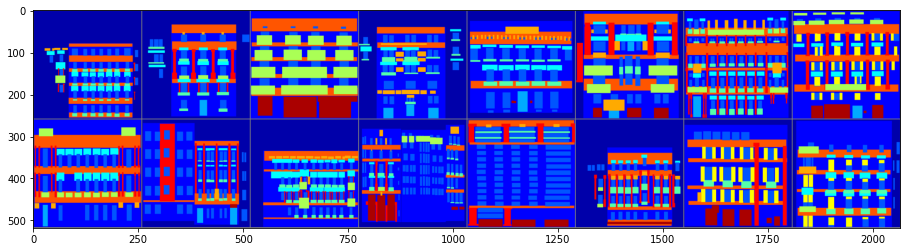

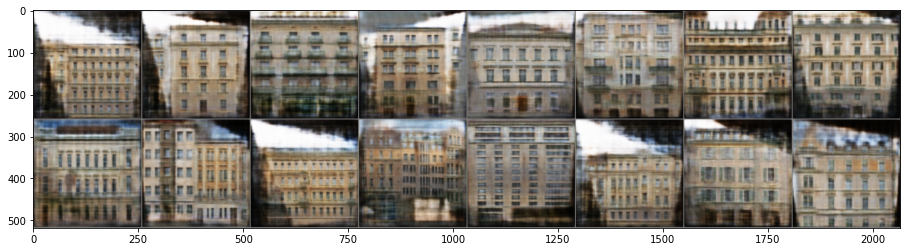

In [46]:
imshow_grid(sample, figsize = (20, 4))
imshow_grid(out, figsize = (20, 4))